In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount("/content/drive", force_remount=True)
%cd /content/drive/My Drive/Colab Notebooks/DCUNET
PATH = "/content/drive/My Drive/Colab Notebooks/DCUNET/DATASET"

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/DCUNET


In [ ]:
import os
import sys
import cv2
import re
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import (CSVLogger)
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from model import DCUNet
from tensorflow.keras.utils import Sequence
from generator_file import My_Generator,SaveImages,ValidPredict
#from evaluation import tversky_loss,tversky,focal_tversky,jacard,dice_coef,iou_loss,dice_coef_loss
from evaluation import load_files,load_model,make_list,class_vector,focal_tversky
#from second_model import unet_model
print(sys.version)
print(tf.__version__)
from os import walk
#tf.config.list_physical_devices('GPU')
#tf.config.gpu.set_per_process_memory_fraction(0.75)
#tf.config.gpu.set_per_process_memory_growth(True)

3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
2.6.0


benign (304).png
228_5_benign (304).png


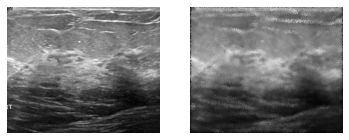

In [ ]:
def plot_augmentations(path_orig,path_aug,n_images=1):
    for i in range(n_images):
        img_orig = cv2.imread(path_orig)
        img_aug = cv2.imread(path_aug)
        ax1 = plt.subplot(1,2, i + 1)
        ax1.imshow(img_orig)
        ax2 = plt.subplot(1, 2, i + 2)
        ax2.imshow(img_aug)
        ax1.axis("off")
        ax2.axis("off")

list_augs = os.listdir('DATASET/augmented_images/images')
sample = random.choice(list_augs)
matches = re.search('[a-z]+\s\(\d+\)\.[a-z]+', sample)
print(matches.group(0))
print(sample)
plot_augmentations(path_orig=f'DATASET/Original/{matches.group(0)}',path_aug=f'DATASET/augmented_images/images/{sample}')

In [ ]:
f = os.listdir('/content/drive/My Drive/Colab Notebooks/DCUNET/DATASET/augmented_images/images')
len(f)

5460

In [ ]:
klase = []
for name in f:
    if 'benign' in name:
        klase.append('benign')
    elif 'normal' in name:
        klase.append('normal')
    else:
        klase.append('malignant')
unique, counts = np.unique(klase, return_counts=True)
ns_of_occ= dict(zip(unique, counts))
ns_of_occ

{'benign': 3059, 'malignant': 1470, 'normal': 931}

In [ ]:
def create_model(input_shape, checkpoint_epoch=0):
    height,width = input_shape
    path = "\\content\\drive\\My Drive\\Colab Notebooks\\DCUNET\\DATASET"
    if checkpoint_epoch==0:
        base_model = DCUNet(height=height, width=width, channels=3)
    else:
        # this line is used if we're using checkpoints by epoch
        #base_model = load_model(f"{path}/ep_{checkpoint_epoch:02d}.h5",custom_objects={"focal_tversky":focal_tversky,"dice_coef":dice_coef,"jacard":jacard})
        base_model = DCUNet(height=height, width=width, channels=3)
        base_model.load_weights('model_checkpoint.h5')
    model = base_model
    return model

In [ ]:
PATH = "/content/drive/My Drive/Colab Notebooks/DCUNET/DATASET"
tf.random.set_seed(42)
np.random.seed(42)
CHECKPOINT_EP = 0
AUGMENTATIONS = True
BATCH_SIZE = 64
BUFFER_SIZE = 1000
LR = 1e-3
OPTIMIZER = Adam(LR,clipnorm=0.001)
EPOCHS = 200
HEIGHT = 96 #96
WIDTH = 128 #128
LOSS= focal_tversky
X = []
Y = []

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = tf.cast(input_mask, tf.float32) / 255.0
  return input_image, input_mask



def parse_image(img,label):
    text = img.numpy().decode('utf-8')
    #text = img
    if str(text)[0].isdigit():
        path = f"/content/drive/My Drive/Colab Notebooks/DCUNET/DATASET/augmented_images/images/{text}"
    else:
        path = f"/content/drive/My Drive/Colab Notebooks/DCUNET/DATASET/Original/{text}"
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [96, 128])

    text = label.numpy().decode('utf-8')
    #text = label
    if str(text)[0].isdigit():
        path = f"/content/drive/My Drive/Colab Notebooks/DCUNET/DATASET/augmented_images/labels/{text}"
    else:
        path = f"/content/drive/My Drive/Colab Notebooks/DCUNET/DATASET/Ground Truth/{text}"
    mask = tf.io.read_file(path)
    mask = tf.image.decode_png(mask,channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [96, 128])
    #img,mask = normalize(img,mask)
    return img,mask

def set_shapes(image, label):
    image,label = tf.py_function(parse_image, [image,label], [tf.float32,tf.float32])
    image.set_shape((96, 128, 3))
    label.set_shape((96, 128, 1))
    return image, label

In [ ]:
def make_list(PATH,augmentations=False):


    original = os.listdir(f'{PATH}/DATASET/Original')
    del_ext = [f.split('.')[0] for f in original]
    mask = [f + '_mask.png' for f in del_ext]
    klase = [f.split(' ')[0] for f in original]
    df = pd.concat([pd.Series(original), pd.Series(mask), pd.Series(klase)], axis=1)
    if augmentations:
        mask_aug = os.listdir(f'{PATH}/DATASET/augmented_images/labels')
        original_aug = os.listdir(f'{PATH}/DATASET/augmented_images/images')
        aug_klase = []
        for orig in original_aug:
            if 'benign' in orig:
                aug_klase.append('benign')
            elif 'malignant' in orig:
                aug_klase.append('malignant')
            elif 'normal' in orig:
                aug_klase.append('normal')
        aug_df = pd.concat([pd.Series(original_aug), pd.Series(mask_aug), pd.Series(aug_klase)], axis=1)
        df = pd.concat([df,aug_df], axis=0)
    return df

def load_files(PATH,df_x,df_y,IMG_size=()):
    mask_list =[]
    original_list=[]

    for i in range(df_x.shape[0]):
        sample = df_x.iloc[i]
        if str(sample)[0].isdigit():
            path = f"{PATH}/DATASET/augmented_images/images/{sample}"
        else:
            path = f"{PATH}/DATASET/Original/{sample}"
        img = cv2.imread(f"{path}")
        img = cv2.resize(img, IMG_size, interpolation=cv2.INTER_CUBIC)
        original_list.append(img)
        label = df_y.iloc[i]
        if str(label)[0].isdigit():
            path = f"{PATH}/DATASET/augmented_images/labels/{label}"
        else:
            path = f"{PATH}/DATASET/Ground Truth/{label}"
        mask = cv2.imread(path)
        mask = cv2.resize(mask, IMG_size, interpolation=cv2.INTER_CUBIC)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask_list.append(mask)
    original_list = np.array(original_list, np.float32) / 255
    mask_list = np.array(mask_list, np.float32) / 255
    mask_list = np.round(mask_list, 0)
    return original_list,mask_list

def class_vector(x):
    klase_1=[]
    for orig in x:
        if 'benign' in orig:
            klase_1.append('benign')
        elif 'malignant' in orig:
            klase_1.append('malignant')
        elif 'normal' in orig:
            klase_1.append('normal')
    return klase_1

class SaveImages(Callback):
    def __init__(self,raw_data = (), batch_size=4, interval=1,HEIGHT=96,WIDTH=128):
        super(Callback, self).__init__()
        self.x,self.y = raw_data
        self.interval = interval
        self.history = []
        self.HEIGHT, self.WIDTH = HEIGHT,WIDTH
        self.PATH = "/content/drive/My Drive/Colab Notebooks/DCUNET"
        klase = [f.split(' ')[0] for f in self.x]
        self.x.reset_index(drop=True, inplace=True)
        self.y.reset_index(drop=True, inplace=True)
        df = pd.concat([self.x, self.y, pd.Series(klase)], axis=1,ignore_index = True)
        self.df = df.head(10)

    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 ==0:
            original_list, mask_list = load_files(self.PATH, self.df.iloc[:,0],self.df.iloc[:,1], (self.WIDTH, self.HEIGHT))  # jebeni cv2
            try:
                os.makedirs(f'images/epoch_{epoch + 1:02d}')
            except:
                pass
            for i in range(len(original_list)):
                X = np.expand_dims(original_list[i], axis=0)
                yp = self.model.predict(x=X, verbose=1)
                yp = np.round(yp, 0)
                plt.figure(figsize=(20, 10))
                plt.subplot(1, 3, 1)
                plt.imshow(original_list[i])
                plt.title('Input')
                plt.subplot(1, 3, 2)
                plt.imshow(mask_list[i].reshape(mask_list[i].shape[0], mask_list[i].shape[1]))
                plt.title('Ground Truth')
                plt.subplot(1, 3, 3)
                plt.imshow(yp[0].reshape(yp[0].shape[0], yp[0].shape[1]))
                plt.title('Prediction')
                plt.savefig(f'images/epoch_{epoch + 1:02d}/' + str(i) + '.png', format='png')
                #plt.show()
                plt.close()

        #self.model.save('my_model.h5')

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 1.0  #0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_pred_f = tf.math.round(y_pred_f)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_pred_f = tf.math.round(y_pred_f)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union

def dice_coef_loss(y_true,y_pred):
    smooth = 1.0  # 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_l= (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - dice_l

def iou_loss(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f + y_pred_f - y_true_f * y_pred_f)
    return 1 - intersection/union

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    y_pred_pos = tf.round(y_pred_pos)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.75
    smooth = 1
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)


def tversky_loss(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.75
    smooth = 1
    res = (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
    return 1 - res
    
def focal_tversky(y_true,y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.75
    smooth = 1
    pt_1 = (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [ ]:
original = os.listdir(f'DATASET/Original')
del_ext = [f.split('.')[0] for f in original]
mask = [f + '_mask.png' for f in del_ext]
klase = [f.split(' ')[0] for f in original]

original_aug = os.listdir(f'DATASET/augmented_images/images')
del_ext_mask = [f.split('.')[0] for f in original_aug]
mask_aug = [f + '_mask.png' for f in del_ext_mask]
aug_klase = class_vector(original_aug)
aug_df = pd.concat([pd.Series(original_aug), pd.Series(mask_aug), pd.Series(aug_klase)], axis=1)

df_orig = pd.concat([pd.Series(original),pd.Series(mask),pd.Series(klase)],axis=1)
if AUGMENTATIONS: 
    df = pd.concat([df_orig,aug_df],axis=0)#aug_df


In [ ]:
def dataset_split(df_orig,aug_df=(),val_pctg=0.01,test_pctg=0.1,augmentations=False):
    if augmentations:
        total_n_samples = df_orig.shape[0]+aug_df.shape[0]
    else:
        total_n_sample = df_orig.shape[0]
    n_val_samples = int(total_n_samples*val_pctg)
    n_test_samples = int(total_n_samples*test_pctg)
    
    x_train, x_test, y_train, y_test = train_test_split(df_orig[0], df_orig[1], test_size=n_test_samples,
                                                      stratify=df_orig[2], random_state=42)
    klase_1=class_vector(x_train)

    x_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    g = pd.concat([x_train,y_train,pd.Series(klase_1)],axis=1)
    g.columns =[0,1,2]
    x_train, x_val, y_train, y_val = train_test_split(g[0], g[1], test_size=n_val_samples,
                                                      stratify=g[2], random_state=42)
    if augmentations:
        x_train = pd.concat([pd.Series(x_train),aug_df[0]])
        y_train = pd.concat([pd.Series(y_train),aug_df[1]])
 
    return (x_train,y_train),(x_val,y_val),(x_test,y_test)

In [ ]:
(x_train,y_train),(x_val,y_val),(x_test,y_test) = dataset_split(df_orig,aug_df,augmentations=AUGMENTATIONS)

In [ ]:
'''
x_train, x_test, y_train, y_test = train_test_split(df[0], df[1], test_size=0.2,
                                                      stratify=df[2], random_state=42)

#klase = [f.split(' ')[0] for f in x_train]

klase_1=class_vector(x_train)
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
g = pd.concat([x_train,y_train,pd.Series(klase_1)],axis=1)
g.columns =[0,1,2]
x_train, x_val, y_train, y_val = train_test_split(g[0], g[1], test_size=0.125,
                                                      stratify=g[2], random_state=42)'''

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#dataset = ds.map(lambda x,y: parse_image(x,y),num_parallel_calls=tf.data.AUTOTUNE)
dataset = ds.map(lambda x,y: set_shapes(x,y), num_parallel_calls=tf.data.AUTOTUNE)
train = dataset.cache().prefetch(10).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
dataset = ds.map(lambda x,y: set_shapes(x,y), num_parallel_calls=tf.data.AUTOTUNE)
val = dataset.cache().prefetch(10).batch(BATCH_SIZE).repeat()#shuffle izmedju

In [ ]:
#train_generator = My_Generator(x_train, y_train, PATH, batch_size=batch_size, is_train=True,IMG_size=(WIDTH,HEIGHT)) #accurate order of width and height
#train_mixup = My_Generator(x_train, y_train, PATH, batch_size=batch_size, is_train=True, mix=False, augment=False,IMG_size=(WIDTH,HEIGHT))
#valid_generator = My_Generator(x_val, y_val, PATH, batch_size=batch_size, is_train=False,IMG_size=(WIDTH,HEIGHT))
save_images_callback = SaveImages(raw_data=(x_train,y_train))
best_save= tf.keras.callbacks.ModelCheckpoint(
    'model_best.h5', monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None)
weights_save= tf.keras.callbacks.ModelCheckpoint(
    'weights.h5', monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=True, mode='auto', save_freq='epoch',
    options=None)
model_checkpoint= tf.keras.callbacks.ModelCheckpoint(
    'model_checkpoint.h5', monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=True, mode='auto', save_freq='epoch',
    options=None)
csv_logger = CSVLogger(filename='v1_training_log.csv', separator=',', append=True)
callbacks_list = [csv_logger,best_save,model_checkpoint,weights_save,save_images_callback]#,end_eval ,save_images_callback,valid_predict

In [ ]:
train

<RepeatDataset shapes: ((None, 96, 128, 3), (None, 96, 128, 1)), types: (tf.float32, tf.float32)>

In [ ]:
model = create_model((HEIGHT,WIDTH),checkpoint_epoch=CHECKPOINT_EP) # (height,width)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_coef, jacard, tversky, 'accuracy'])

In [ ]:
#for image,mask in dataset.cache().take(10):
#    print(image,mask)


In [ ]:
#x_val_list,y_val_mask_list = load_files(r"/content/drive/My Drive/Colab Notebooks/DCUNET",x_val,y_val,(WIDTH,HEIGHT))

In [ ]:
model.fit(
    train,
    validation_data=val,
    steps_per_epoch=int(np.ceil(float(len(x_train)) / float(BATCH_SIZE))),
    validation_steps = int(np.ceil(float(len(x_val)) / float(BATCH_SIZE))),
    epochs=EPOCHS,
    verbose=1,initial_epoch=CHECKPOINT_EP,callbacks=callbacks_list)#validation_steps = int(np.ceil(float(len(x_val)) / float(BATCH_SIZE)));steps_per_epoch=int(np.ceil(float(len(x_train)) / float(BATCH_SIZE)))

Epoch 1/200
69/69 [==============================] - 3088s 35s/step - loss: 0.7376 - dice_coef: 0.3509 - jacard: 0.2164 - tversky: 0.4932 - accuracy: 0.7499 - val_loss: 0.8100 - val_dice_coef: 0.1380 - val_jacard: 0.0743 - val_tversky: 0.2418 - val_accuracy: 0.0730


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1/1 [==============================] - 0s 23ms/step
Epoch 2/200
69/69 [==============================] - 54s 781ms/step - loss: 0.7068 - dice_coef: 0.4543 - jacard: 0.2962 - tversky: 0.6048 - accuracy: 0.8318 - val_loss: 0.7832 - val_dice_coef: 0.2385 - val_jacard: 0.1358 - val_tversky: 0.3742 - val_accuracy: 0.5823
Epoch 3/200
69/69 [==============================] - 55s 799ms/step - loss: 0.6928 - dice_coef: 0.5209 - jacard: 0.3545 - tversky: 0.6662 - accuracy: 0.8705 - val_loss: 0.7834 - val_dice_coef: 0.2903 - val_jacard: 0.1704 - val_tversky: 0.4214 - val_accuracy: 0.7178
Epoch 4/200
69/69 [==============================] - 56s 813ms/step - loss: 0.6816 - dice_coef: 0.5773 - jacard: 0.4092 - tversky: 0.7128 - accuracy: 0.8956 - val_loss: 0.8046 - val_dice_coef: 0.2338 - val_jacard: 0.1328 - val_tversky: 0.3030 - val_accuracy: 0.7867
Epoch 5/200
69/69 [==============================] - 57s 819ms/step - loss: 0.6689 - dice_coef: 0.6302 - jacard: 0.4631 - tversky: 0.7556 - accuracy: 

In [ ]:
model1 = create_model((HEIGHT,WIDTH),checkpoint_epoch=CHECKPOINT_EP)
model1.load_weights('model_best.h5')

In [ ]:
model1.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_coef, jacard, tversky, 'accuracy'])

In [ ]:
loss,result_dice,result_jaccard,result_tversky,accuracy =model1.evaluate(val,steps=int(np.ceil(float(len(x_val)) / float(BATCH_SIZE))))

1/1 [==============================] - 51s 51s/step - loss: 0.4033 - dice_coef: 0.9868 - jacard: 0.9739 - tversky: 0.9865 - accuracy: 0.9963


In [ ]:
result_jaccard

0.9738688468933105

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
dataset = ds.map(lambda x,y: set_shapes(x,y), num_parallel_calls=tf.data.AUTOTUNE)
val = dataset.cache().prefetch(10).batch(BATCH_SIZE).repeat()#shuffle izmedju
loss,result_dice,result_jaccard,result_tversky,accuracy =model1.evaluate(val,steps=int(np.ceil(float(len(x_val)) / float(BATCH_SIZE))))

1/1 [==============================] - 42s 42s/step - loss: 0.4295 - dice_coef: 0.9809 - jacard: 0.9625 - tversky: 0.9791 - accuracy: 0.9958


In [ ]:
print(loss,result_dice,result_jaccard,result_tversky,accuracy)

0.4295187294483185 0.9809028506278992 0.9625210762023926 0.9790878891944885 0.9957758784294128


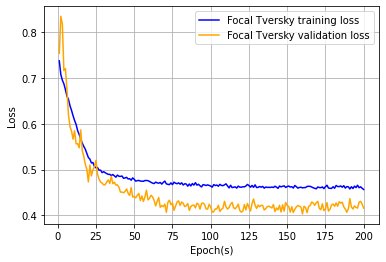

In [ ]:
df= pd.read_csv(f"/content/drive/My Drive/Colab Notebooks/DCUNET/v1_training_log.csv")
#print(df.iloc[:,:4].head(10))
#plt.plot(np.arange(1,301),tr_metrics.iloc[:,1])
line1, = plt.plot(np.arange(1,201),df.iloc[:200,4],'b',label='Focal Tversky training loss')
line2, = plt.plot(np.arange(1,201),df.iloc[:200:,9],'orange',label='Focal Tversky validation loss')
plt.legend(handles=[line1, line2])
plt.grid()
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
#plt.ylim(0,1)
plt.show()

In [ ]:
#x_val_list,y_val_mask_list = load_files(r"/content/drive/My Drive/Colab Notebooks/DCUNET",x_val,y_val,(WIDTH,HEIGHT))

In [ ]:
averagek= []
for i in range(len(x_val_list)):
    x_val = np.expand_dims(x_val_list[i], axis=0)
    y_val = np.expand_dims(y_val_mask_list[i],axis=0)
    res = model.evaluate(x_val,y_val)
    res1 = model1.evaluate(x_val,y_val)
    if i % 10:
        print('Novi rez')
        print(res)
        print(res1)
        averagek.append(res[0])
    #print(res1)
print(np.sum(averagek)/len(averagek))

In [ ]:
print(np.sum(averagek)/len(averagek))

0.8321516522339412


In [ ]:
average_tversky = []
average_dice = []
average_jaccard = []
for i in range(len(x_val_list)):
    x = np.expand_dims(x_val_list[i], axis=0)
    y = np.expand_dims(y_val_mask_list[i], axis=0)
    loss,result_dice,result_jaccard,result_tversky,accuracy = model1.evaluate(x, y)
    #print(f"Dice coef: {result_dice}; Result jaccard: {result_jaccard}; Result tversky: {result_tversky}")
    average_tversky.append(result_tversky)
    average_jaccard.append(result_jaccard)
    average_dice.append(result_dice)

In [ ]:
print(np.mean(average_tversky))
print(np.mean(average_jaccard))
print(np.mean(average_dice))

0.20743459227751607
0.07556442551625271
0.12963500190054242


In [ ]:
x_val_list,y_val_mask_list = load_files(r"/content/drive/My Drive/Colab Notebooks/DCUNET",x_val,y_val,(WIDTH,HEIGHT))
model2 = create_model((HEIGHT,WIDTH),checkpoint_epoch=CHECKPOINT_EP)
model2.load_weights('model_best.h5')
model2.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_coef, jacard, tversky, 'accuracy'])
average_tversky = []
average_dice = []
average_jaccard = []
for i in range(len(x_val_list)):
    x = np.expand_dims(x_val_list[i], axis=0)
    y = np.expand_dims(y_val_mask_list[i], axis=0)
    loss,result_dice,result_jaccard,result_tversky,accuracy = model2.evaluate(x, y)
    #print(f"Dice coef: {result_dice}; Result jaccard: {result_jaccard}; Result tversky: {result_tversky}")
    average_tversky.append(result_tversky)
    average_jaccard.append(result_jaccard)
    average_dice.append(result_dice)

klase_2 = class_vector(x_train)# change here
average_jaccard=pd.Series(average_jaccard).fillna(1)
new_df = pd.concat([pd.Series(klase_2),average_jaccard,pd.Series(average_tversky),pd.Series(average_dice)],axis=1)
new_df.columns = ['class','jaccard','tversky','dice']
print(new_df)
#new_df.to_csv(f'{model_path}\\results_test.csv',columns=['class','jaccard','tversky','dice'])

df= pd.read_csv(f"v1_training_log.csv",index_col=0)
best_column = df[df['val_loss']==df['val_loss'].min()]
print(best_column)
print(f"Average tversky on test set is {np.mean(average_tversky)}; Tversky on validation: {best_column['val_tversky'].to_numpy()[0]}; "
      f"Tversky on training: {best_column['tversky'].to_numpy()[0]}")
print(f"Average jaccard on test set is {np.mean(average_jaccard)}; Jaccard on validation: {best_column['val_jacard'].to_numpy()[0]}; "
      f"Jaccard on training: {best_column['jacard'].to_numpy()[0]}")
print(f"Average dice on test set is {np.mean(average_dice)}; Dice on validation: {best_column['val_dice_coef'].to_numpy()[0]}; "
      f"Dice on training: {best_column['dice_coef'].to_numpy()[0]}")


print(new_df.groupby(['class']).mean())
print(new_df.groupby(['class']).count())

1/1 [==============================] - 1s 634ms/step - loss: 0.3691 - dice_coef: 0.9857 - jacard: 0.9718 - tversky: 0.9840 - accuracy: 0.9966
          class   jaccard   tversky      dice
0        benign  0.941176  0.967880  0.969828
1        benign  1.000000  1.000000  1.000000
2        normal  1.000000  1.000000  1.000000
3     malignant  1.000000  1.000000  1.000000
4        benign  0.941788  0.976344  0.970053
...         ...       ...       ...       ...
5549     benign       NaN       NaN       NaN
5550     benign       NaN       NaN       NaN
5551     benign       NaN       NaN       NaN
5552     benign       NaN       NaN       NaN
5553     benign       NaN       NaN       NaN

[5554 rows x 4 columns]
       accuracy  dice_coef    jacard  ...  val_jacard  val_loss  val_tversky
epoch                                 ...                                   
159    0.995484   0.986556  0.973478  ...    0.973869  0.403313     0.986543

[1 rows x 10 columns]
Average tversky on test set